In [24]:
import pystac
import stackstac
import geopandas as gpd
import hvplot.xarray
from dask.distributed import Client
import rioxarray
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc 
import matplotlib.animation as an # for FuncAnimation
from IPython.display import HTML
import pandas as pd
from datetime import datetime

In [25]:
# MODIFY PARAMETERS

#-------------------------------------------------------------------------
# comment ONE of these out at a time
relative_orbit_number = 137 # change to get any particular relative orbit
#orbit_direction = 'ascending' # 'ascending', descending', 'all'
#-------------------------------------------------------------------------
# define time slice
today = datetime.today().strftime('%Y-%m-%d')
time_slice = slice('2020-01-01','2020-12-31') # All of 2020
#time_slice = slice('2017-01-01',today)
#-------------------------------------------------------------------------
polarization ='gamma0_vv'
#-------------------------------------------------------------------------
show_full_collection = False
show_cropped_collection = False
show_video_all = False
show_video_ascending = False
show_video_descending = False
show_animation = False
save_gif = True
gif_fps = 4

In [26]:
if 'relative_orbit_number' in locals():
    by_orbit = True
else: 
    by_orbit = False

In [27]:
# GDAL environment variables for better performance
os.environ['AWS_REGION']='us-west-2'
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' 
os.environ['AWS_NO_SIGN_REQUEST']='YES' 

In [28]:
# Paste /proxy/localhost:8787 for cluster diagnostics
client = Client(local_directory='/tmp', processes=False)
#client

/mnt/working/egagli/sw/miniconda3/envs/aws-rtc-stac2/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35479 instead
  warnings.warn(


In [29]:
# Load STAC ItemCollection
stac_items = pystac.ItemCollection.from_file('mycollection.json')
items = [item.to_dict(transform_hrefs=False) for item in stac_items]
stack = stackstac.stack(items,dtype='float32')
#stack

In [30]:
# view full scene
if show_full_collection:
    gamma0_vv_full = stack.sel(band=polarization)

    gamma0_vv_full.hvplot.image(x='x', y='y',
                          rasterize=True,
                          data_aspect=1,
                          title=f'{polarization}',
                          clim=(0,0.4), # not equal to vv scale
                          cmap='gray',
                          clabel=f'{polarization} (watts)')

In [31]:
# import area bounding box
rainier_gf = gpd.read_file('shapefiles/mt_rainier.geojson')
rainier_utm_gf = rainier_gf.to_crs(stack.crs)
xmin, ymax, xmax, ymin = rainier_utm_gf.bounds.values[0]

In [32]:
# crop scene
gamma0_vv = stack.sel(band=polarization).sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)

In [33]:
# view cropped scene
if show_cropped_collection:
    gamma0_vv.hvplot.image(x='x', y='y',
                          rasterize=True,
                          data_aspect=1,
                          title=f'{polarization}',
                          clim=(0,0.4), # not equal to vv scale
                          cmap='gray',
                          clabel=f'{polarization} (watts)')

In [34]:
%%time
# compute frames
frames_all = gamma0_vv.compute()

CPU times: user 6.12 s, sys: 819 ms, total: 6.94 s
Wall time: 4.51 s


In [35]:
# drop missing data
frames = frames_all.dropna('time',how='all')

In [36]:
# view all acquisitions
if show_video_all:
    video = frames.hvplot.image(x='x',y='y', clim=(0,0.4), aspect='equal', frame_width=600, cmap='gray', 
                                     widget_type='scrubber', widget_location='bottom') 
    video

In [37]:
# view ascending
if show_video_ascending:
    video = frames.where(frames.coords['sat:orbit_state']=='ascending',drop=True).hvplot.image(x='x',y='y', clim=(0,0.4), aspect='equal', frame_width=600, cmap='gray', 
                                     widget_type='scrubber', widget_location='bottom') 
    video

In [38]:
# view descending
if show_video_descending:
    video = frames.where(frames.coords['sat:orbit_state']=='descending',drop=True).hvplot.image(x='x',y='y', clim=(0,0.4), aspect='equal', frame_width=600, cmap='gray', 
                                     widget_type='scrubber', widget_location='bottom') 
    video

In [39]:
# bring in glacier shapefiles
rainier_glaciers = gpd.read_file('shapefiles/rainier_glaciers.geojson')
rainier_glaciers = rainier_glaciers.to_crs(stack.crs)

In [40]:
# filter by orbit direction or orbit number
if by_orbit:
    frames = frames.where(frames.coords['sat:relative_orbit']==relative_orbit_number,drop=True)
    orbit_directions = frames.coords['sat:orbit_state']
    orbit_direction = orbit_directions[0].values
elif orbit_direction == 'all':
    frames = frames
else:
    frames = frames.where(frames.coords['sat:orbit_state']==orbit_direction,drop=True)

In [41]:
# choose shapefiles
nis = rainier_glaciers[rainier_glaciers['Name'] == 'Nisqually Glacier WA']
emm = rainier_glaciers[rainier_glaciers['Name'] == 'Emmons Glacier WA']
car = rainier_glaciers[rainier_glaciers['Name'] == 'Carbon Glacier WA']
tah = rainier_glaciers[rainier_glaciers['Name'] == 'Tahoma Glacier WA']

In [42]:
# crop frames to glacier outlines
frames_nis = frames.rio.clip(nis.geometry,rainier_glaciers.crs,drop=True,invert=False)
frames_emm = frames.rio.clip(emm.geometry,rainier_glaciers.crs,drop=True,invert=False) 
frames_car = frames.rio.clip(car.geometry,rainier_glaciers.crs,drop=True,invert=False) 
frames_tah = frames.rio.clip(tah.geometry,rainier_glaciers.crs,drop=True,invert=False) 
frames_named = frames.rio.clip(rainier_glaciers.geometry,rainier_glaciers.crs,drop=False,invert=False) 

In [43]:
# convert datetimes
tindex = pd.to_datetime(frames.coords['time'])

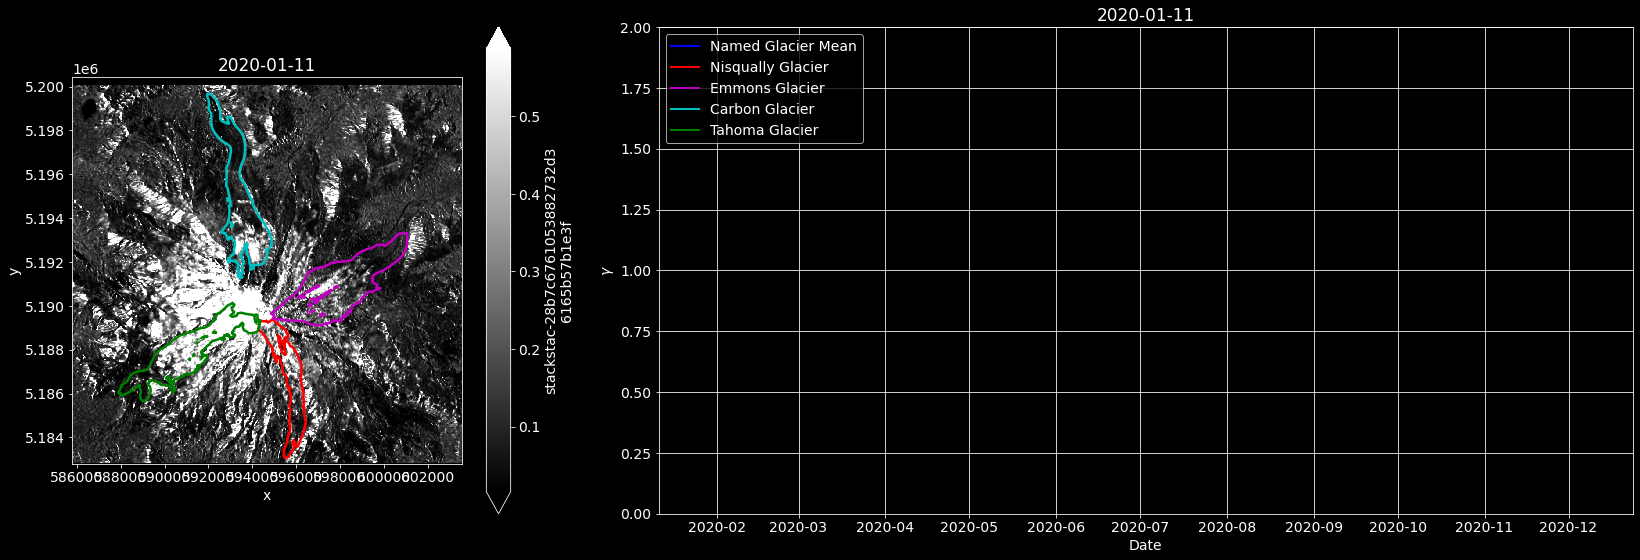

In [44]:
# create animation
if show_animation or save_gif:
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23, 8), gridspec_kw={'width_ratios':[1, 2]})
    plt.rcParams.update({'font.size': 14})
    vmin = np.nanpercentile(frames.squeeze(), 5)
    vmax = np.nanpercentile(frames.squeeze(), 95)

    im = frames.isel(time=0).plot.imshow(ax=ax1,cmap='gray', vmin=vmin, vmax=vmax)

    nis.geometry.plot(ax=ax1,alpha=1,linewidth=2.5,facecolor='none',edgecolor='r')
    emm.geometry.plot(ax=ax1,alpha=1,linewidth=2.5,facecolor='none',edgecolor='m')
    car.geometry.plot(ax=ax1,alpha=1,linewidth=2.5,facecolor='none',edgecolor='c')
    tah.geometry.plot(ax=ax1,alpha=1,linewidth=2.5,facecolor='none',edgecolor='g')

    ax1.set_xlim((xmin, xmax))
    ax1.set_ylim((ymax, ymin))

    ax1.set_title("{}".format(tindex[0].date()))
    ax2.set_title("{}".format(tindex[0].date()))

    #ax1.set_axis_off()
    ax2.axis([tindex[0].date(), tindex[-1].date(), 0, 1])
    plt.rcParams.update({'font.size': 14})
    ax2.set_ylabel('$\gamma$')
    ax2.set_xlabel('Date')
    ax2.set_ylim((0, 2))
    ax2.grid()
    l, = ax2.plot([], [],'b',linewidth=2,label='Named Glacier Mean')
    l_nis, = ax2.plot([], [],'r',linewidth=2,label='Nisqually Glacier')
    l_emm, = ax2.plot([], [],'m',linewidth=2,label='Emmons Glacier')
    l_car, = ax2.plot([], [],'c',linewidth=2,label='Carbon Glacier')
    l_tah, = ax2.plot([], [],'g',linewidth=2,label='Tahoma Glacier')
    ax2.legend(loc='upper left')
    plt.tight_layout()



    def animate(i):
        ax1.set_title("{}".format(tindex[i].date()))
        im.set_data(frames.isel(time = i))

        ax2.set_title("{}".format(tindex[i].date()))
        l.set_data(tindex[:(i+1)], frames_named[:(i+1)].mean(dim=['x','y']))
        l_nis.set_data(tindex[:(i+1)], frames_nis[:(i+1)].mean(dim=['x','y']))
        l_emm.set_data(tindex[:(i+1)], frames_emm[:(i+1)].mean(dim=['x','y']))
        l_car.set_data(tindex[:(i+1)], frames_car[:(i+1)].mean(dim=['x','y']))
        l_tah.set_data(tindex[:(i+1)], frames_tah[:(i+1)].mean(dim=['x','y']))

    # Interval is given in milliseconds
    rc('animation', embed_limit=40971520.0)
    ani = an.FuncAnimation(fig, animate, frames=len(tindex), interval=200,blit=False,repeat=False)

In [45]:
%%time
# save to animation to play in notebook
if show_animation:
    HTML(ani.to_jshtml())

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


In [46]:
%%time
# save to gif in output folder
if save_gif:
    if by_orbit:
        ani.save(f'output/time_series_gif/rainier_{polarization}_{time_slice.start}_{time_slice.stop}_{orbit_direction}_{relative_orbit_number}.gif', writer='pillow', fps=gif_fps)
    else:
        ani.save(f'output/time_series_gif/rainier_{polarization}_{time_slice.start}_{time_slice.stop}_{orbit_direction}.gif', writer='pillow', fps=gif_fps)


CPU times: user 4.14 s, sys: 293 ms, total: 4.43 s
Wall time: 4.32 s
